In [49]:
import argparse
import os
import sys

import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

sys.path.insert(0, "..")

from powerful_benchmarker.utils.constants import add_default_args
from validator_tests.eval_validators import (
    _get_best_accuracy_per_adapter,
    _get_correlation,
    group_by_task_validator,
)
from validator_tests.utils import create_main
from validator_tests.utils.constants import TARGET_ACCURACY, add_exp_group_args
from validator_tests.utils.df_utils import get_name_from_df, unify_validator_columns
from validator_tests.utils.plot_val_vs_acc import _scatter_plot, scatter_plot

In [7]:
def get_folder_name(folder, full_df):
    return os.path.join(folder, get_name_from_df(full_df, assert_one_task=True))


def save_boxplot(folder_name, df, x, y, filename, figsize=(4.8, 4.8)):
    sns.set(style="whitegrid", rc={"figure.figsize": figsize})
    plot = sns.boxplot(data=df, x=x, y=y)
    fig = plot.get_figure()
    fig.savefig(
        os.path.join(folder_name, f"{filename}.png"),
        bbox_inches="tight",
    )
    fig.clf()


def plot_globally_ranked(folder_name, one_adapter, x_name, adapter_name):
    groupby = group_by_task_validator(per_adapter=True)
    ranks = one_adapter.groupby(groupby)["score"].rank(method="min", ascending=False)
    one_adapter["rank"] = ranks
    scatter_plot(
        folder_name,
        df=one_adapter,
        x=x_name,
        y=TARGET_ACCURACY,
        filename=f"{adapter_name}_all",
        c="rank",
        figsize=(4.8, 4.8),
    )
    scatter_plot(
        folder_name,
        df=one_adapter[one_adapter["rank"] < 200],
        x=x_name,
        y=TARGET_ACCURACY,
        filename=f"{adapter_name}_top200",
        figsize=(4.8, 4.8),
        s=1,
    )
    return one_adapter


def plot_trial_ranked(folder_name, one_adapter, x_name, adapter_name):
    one_adapter = _get_best_accuracy_per_adapter(
        one_adapter, nlargest=100, rank_by="score", return_ranks=True
    )
    scatter_plot(
        folder_name,
        df=one_adapter,
        x=x_name,
        y=TARGET_ACCURACY,
        filename=f"{adapter_name}_per_trial",
        c="rank",
        figsize=(4.8, 4.8),
        s=1,
    )
    scatter_plot(
        folder_name,
        df=one_adapter[one_adapter["rank"] < 5],
        x=x_name,
        y=TARGET_ACCURACY,
        filename=f"{adapter_name}_per_trial_top5",
        figsize=(4.8, 4.8),
        s=1,
    )
    return one_adapter


def plot_best_pairs(folder_name, df):
    df = unify_validator_columns(
        df, new_col_name="unified_validator", drop_validator_args=False
    )
    best_validators = [
        (
            x,
            "BNMSummedSrcVal_layer_logits"
            if x == "ATDOCConfig"
            else "Accuracy_average_micro_split_src_val",
        )
        for x in adapter_names()
    ]
    mask = False
    for adapter, validator in best_validators:
        mask |= (df["adapter"] == adapter) & (df["unified_validator"] == validator)
    df = df[mask]
    gdf = plot_globally_ranked(folder_name, df, "adapter", "ALL")
    tdf = plot_trial_ranked(folder_name, df, "adapter", "ALL")
    gdf = gdf.sort_values(by=["adapter"])
    tdf = tdf.sort_values(by=["adapter"])

    save_boxplot(
        folder_name,
        gdf[gdf["rank"] < 200],
        "adapter",
        TARGET_ACCURACY,
        "AAA_best_pairs_global_boxplot",
    )
    save_boxplot(
        folder_name,
        tdf[tdf["rank"] < 5],
        "adapter",
        TARGET_ACCURACY,
        "AAA_best_pairs_per_trial_boxplot",
    )


def adapter_names():
    return [
        "ATDOCConfig",
        "BNMConfig",
        "BSPConfig",
        "CDANConfig",
        "DANNConfig",
        "GVBConfig",
        "IMConfig",
        "MCCConfig",
        "MCDConfig",
        "MMDConfig",
    ]


def get_global_ranks(df, rank_by):
    groupby = group_by_task_validator(per_adapter=True)
    corr_with_ranks = df.copy()
    ranks = corr_with_ranks.groupby(groupby)[rank_by].rank(
        method="min", ascending=False
    )
    corr_with_ranks["rank"] = ranks
    return corr_with_ranks


def plot_corr_vs_acc(df, max_rank, corr_name):
    to_plot = df[df["rank"] <= max_rank]
    to_plot = to_plot.sort_values(by=["adapter"])
    to_plot["adapter"] = to_plot["adapter"].str.replace("Config", "")
    sns.set(style="whitegrid", rc={"figure.figsize": (8, 8)})
    plot = sns.scatterplot(
        data=to_plot, x=corr_name, y=TARGET_ACCURACY, hue="rank_type", alpha=0.5
    )
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))


def plot_corr_vs_true_and_predicted(best, max_rank, corr_name):
    plot_corr_vs_acc(best, max_rank, corr_name)

In [8]:
df1 = pd.read_pickle()
df2 = pd.read_pickle()
df = pd.concat([df1, df2], axis=0)

In [9]:
corr_name = "weighted_spearman"
corr = _get_correlation(df.copy(), True, 0.0, corr_name)
corr = pd.melt(
    corr,
    id_vars=["validator", "validator_args", "task"],
    value_vars=adapter_names(),
    var_name="adapter",
    value_name=corr_name,
)
assert len(corr["task"].unique()) == 1
corr = corr.merge(df)
corr = unify_validator_columns(
    corr, new_col_name="unified_validator", drop_validator_args=False
)
best_validators = [
    (
        x,
        "BNMSummedSrcVal_layer_logits"
        if x == "ATDOCConfig"
        else "Accuracy_average_micro_split_src_val",
    )
    for x in adapter_names()
]
mask = False
for adapter, validator in best_validators:
    mask |= (corr["adapter"] == adapter) & (corr["unified_validator"] == validator)
corr_best_validators = corr[mask]

In [87]:
import importlib

import validator_tests.eval_validators

importlib.reload(validator_tests.eval_validators)

best_by_score = _get_best_accuracy_per_adapter(
    corr_best_validators.copy(), nlargest=10000, rank_by="score", return_ranks=True
)

s = {"spearman_correlation": [], "metric": [], "nlargest": []}
p = {"pearson_correlation": [], "metric": [], "nlargest": []}

for nlargest in range(1, 201):
    curr = best_by_score.copy()
    curr = curr[curr["rank"] <= nlargest]
    curr["min"] = curr.groupby(["adapter"])[TARGET_ACCURACY].transform("min")
    curr["mean"] = curr.groupby(["adapter"])[TARGET_ACCURACY].transform("mean")
    curr = curr[["adapter", corr_name, "min", "mean"]].drop_duplicates()

    min_accs = curr["min"].values
    mean_accs = curr["mean"].values
    wsc = curr[corr_name].values

    s["spearman_correlation"].append(spearmanr(min_accs, mean_accs).correlation)
    p["pearson_correlation"].append(pearsonr(min_accs, mean_accs)[0])
    s["metric"].append("mean_acc")
    p["metric"].append("mean_acc")
    s["nlargest"].append(nlargest)
    p["nlargest"].append(nlargest)

    s["spearman_correlation"].append(spearmanr(min_accs, wsc).correlation)
    p["pearson_correlation"].append(pearsonr(min_accs, wsc)[0])
    s["metric"].append("weighted_spearman_correlation")
    p["metric"].append("weighted_spearman_correlation")
    s["nlargest"].append(nlargest)
    p["nlargest"].append(nlargest)

s = pd.DataFrame.from_dict(s)
p = pd.DataFrame.from_dict(p)

<AxesSubplot:xlabel='nlargest', ylabel='spearman_correlation'>

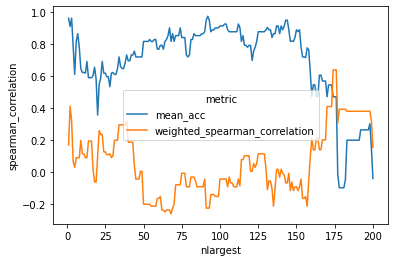

In [88]:
sns.lineplot(data=s, x="nlargest", y="spearman_correlation", hue="metric")

<AxesSubplot:xlabel='nlargest', ylabel='pearson_correlation'>

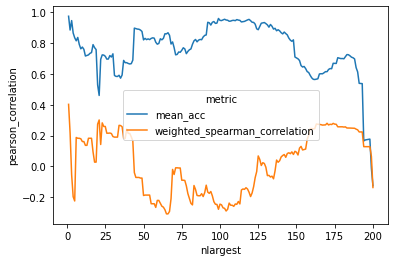

In [89]:
sns.lineplot(data=p, x="nlargest", y="pearson_correlation", hue="metric")